# Clustering and Fitting

In [2]:
import cloudpickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans  # Or DBSCAN, AgglomerativeClustering
from sklearn.ensemble import GradientBoostingRegressor  # Replace with your model of choice
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

In [3]:
X_cleaned_sample = pd.read_csv('airbnb_sample.csv') # airbnb_sample
V = X_cleaned_sample.drop(columns= 'city')

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(V)

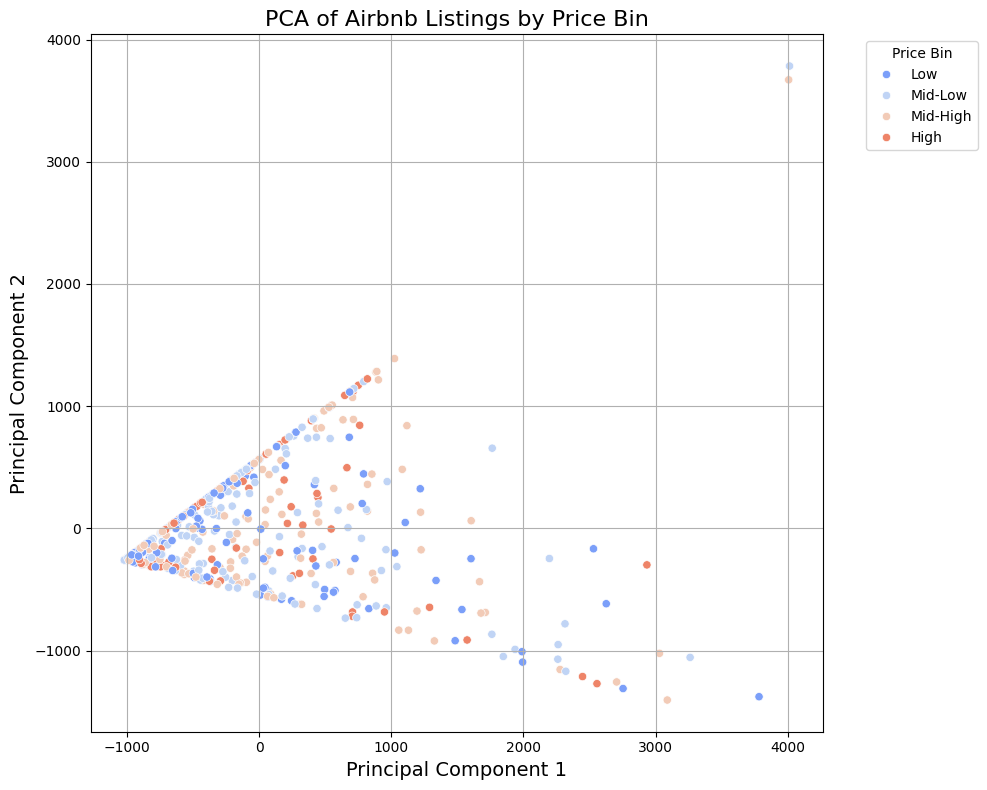

In [5]:
X_cleaned_sample['price_bin'] = pd.qcut(np.exp(X_cleaned_sample['log_price']), q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=X_cleaned_sample['price_bin'],
    palette='coolwarm'
)

plt.title('PCA of Airbnb Listings by Price Bin', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Price Bin', bbox_to_anchor=(1.05, 1), loc='upper left')  # Push legend outside
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: >

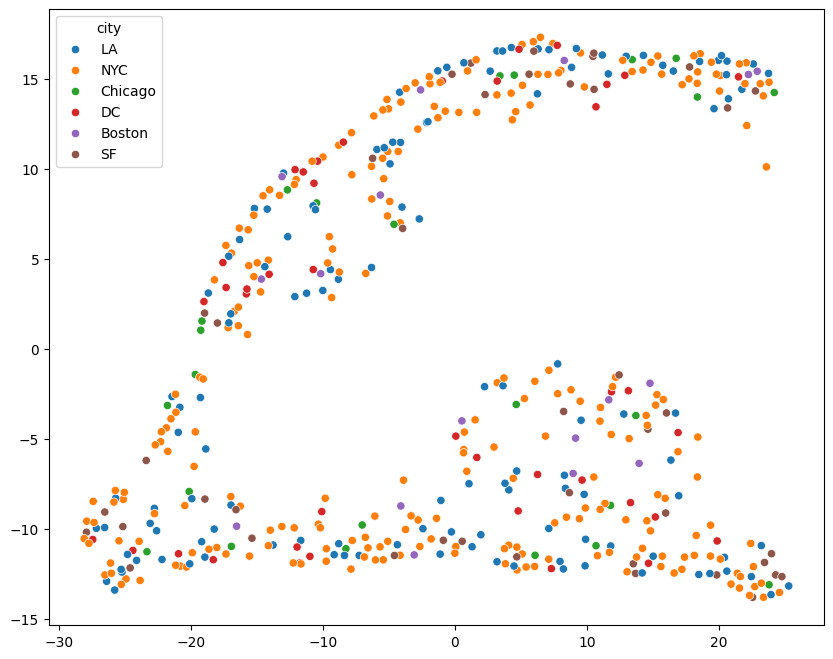

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(V)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=X_cleaned_sample['city'])


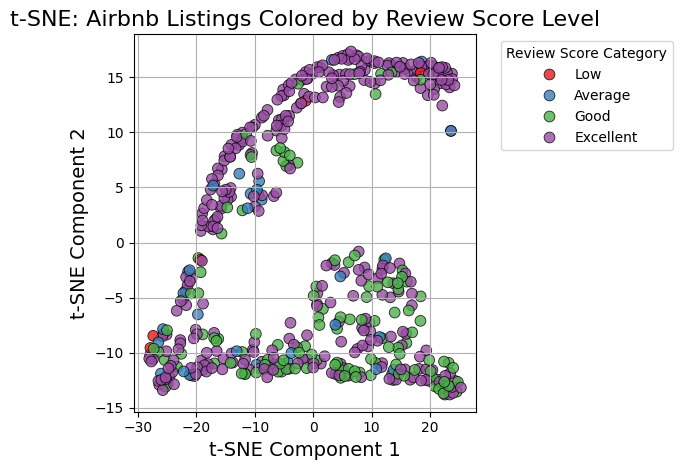

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Bin review scores into categories
X_cleaned_sample['rating_level'] = pd.cut(
    X_cleaned_sample['review_scores_rating'],
    bins=[0, 70, 85, 95, 100],
    labels=['Low', 'Average', 'Good', 'Excellent']
)

# 2. Plot with clearer discrete colors
#plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=X_cleaned_sample['rating_level'],
    palette='Set1',  # Try also 'Set2', 'Dark2', or 'tab10'
    s=60,
    edgecolor='black',
    alpha=0.8
)

plt.title('t-SNE: Airbnb Listings Colored by Review Score Level', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(title='Review Score Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


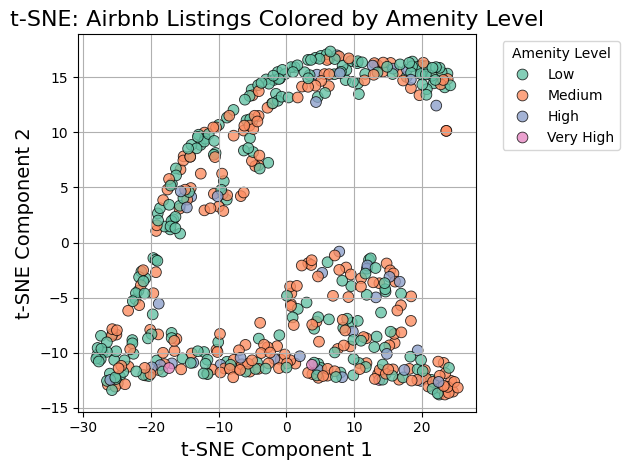

In [8]:

# 1. Bin the 'n_amenities' feature into categories
X_cleaned_sample['amenity_level'] = pd.cut(
    X_cleaned_sample['n_amenities'],
    bins=[0, 15, 25, 40, 100],  # adjust bins as needed
    labels=['Low', 'Medium', 'High', 'Very High']
)

# 2. Plot with better coloring
#plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=X_cleaned_sample['amenity_level'],
    palette='Set2',  # or try 'Dark2', 'tab10', etc.
    s=60,
    edgecolor='black',
    alpha=0.8
)

plt.title('t-SNE: Airbnb Listings Colored by Amenity Level', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(title='Amenity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
import pandas as pd
import optuna

class ClusterFit:
    def __init__(self, cluster_features, n_clusters=4, model_class=RandomForestRegressor, model_params=None):
        self.cluster_features = cluster_features
        self.n_clusters = n_clusters
        self.model_class = model_class
        self.model_params = model_params or {}
        self.scaler = StandardScaler()
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.models = {}
    def get_params(self, deep=True):
        return {
        "cluster_features": self.cluster_features,
        "n_clusters": self.n_clusters,
        "model_class": self.model_class,
        "model_params": self.model_params
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def fit(self, X, y):
        X_cluster = self.scaler.fit_transform(X[self.cluster_features])
        clusters = self.kmeans.fit_predict(X_cluster)
        model = self.model_class(**self.model_params)
        self.cluster_assignments_ = clusters
        self.unique_clusters_ = np.unique(clusters)

        self.X_test_all = []
        self.y_test_all = []

        for cluster in self.unique_clusters_:
            idx = clusters == cluster
            X_cluster_data = X[idx].drop(columns=['log_price', 'cluster_label'], errors='ignore')
            y_cluster = y[idx]
            X_train, X_test, y_train, y_test = train_test_split(X_cluster_data, y_cluster, test_size=0.2, random_state=42)

            model = self.model_class(**self.model_params)
            model.fit(X_train, y_train)
            self.models[cluster] = model
            self.X_test_all.append(X_test)
            self.y_test_all.append(y_test)

    def predict(self, X):
        X_cluster = self.scaler.transform(X[self.cluster_features])
        clusters = self.kmeans.predict(X_cluster)

        preds = np.zeros(len(X))
        for cluster in self.unique_clusters_:
            idx = clusters == cluster
            if np.sum(idx) == 0:
                continue
            X_cluster_data = X.iloc[idx].drop(columns=['log_price', 'cluster_label'], errors='ignore')
            preds[idx] = self.models[cluster].predict(X_cluster_data)
        return preds

    def score(self, X, y_true):
        y_true = pd.concat(self.y_test_all)
        y_pred = []
        for X_test, cluster in zip(self.X_test_all, self.unique_clusters_):
            preds = self.models[cluster].predict(X_test)
            y_pred.extend(preds)
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def cross_val_rmse(self, X, y, cv=5):
        scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
        scores = cross_val_score(self, X, y, cv=cv, scoring=scorer)
        return -np.mean(scores), np.std(scores)

    def set_params(self, **params):
        self.model_params = params


def optimize_cluster_fit(X, y, cluster_features, model_type, n_clusters=3, n_trials=50, timeout=600):
    def objective(trial):
        if model_type == "RandomForest":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'random_state': 42,
                'n_jobs': -1
            }
            model_class = RandomForestRegressor

        elif model_type == "Ridge":
            params = {
                'alpha': trial.suggest_float('alpha', 0.01, 10.0),
                'random_state': 42
            }
            model_class = Ridge

        elif model_type == "GradientBoostingRegressor":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'random_state': 42
            }
            model_class = GradientBoostingRegressor
        elif model_type == "Lasso":
            params = {
                "alpha": trial.suggest_float("alpha", 1e-4, 1.0, log=True),
                "random_state": 42
            }
            model_class = Lasso

        elif model_type == "ElasticNet":
            params = {
                "alpha": trial.suggest_float("alpha", 1e-4, 1.0, log=True),
                "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
                "random_state": 42
            }
            model_class = ElasticNet

        elif model_type == "ExtraTreesRegressor":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "max_depth": trial.suggest_int("max_depth", 3, 15),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "random_state": 42,
                "n_jobs": -1
            }
            model_class = ExtraTreesRegressor

        elif model_type == "HistGradientBoostingRegressor":
            params = {
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "max_iter": trial.suggest_int("max_iter", 100, 500),
                "max_depth": trial.suggest_int("max_depth", 3, 15),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
                "l2_regularization": trial.suggest_float("l2_regularization", 1e-4, 1.0, log=True),
                "random_state": 42
            }
            model_class = HistGradientBoostingRegressor

        elif model_type == "SVR":
            params = {
                "C": trial.suggest_float("C", 0.1, 100, log=True),
                "epsilon": trial.suggest_float("epsilon", 0.01, 1.0, log=True),
                "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"]),
            }
            model_class = SVR

        elif model_type == "KNeighborsRegressor":
            params = {
                "n_neighbors": trial.suggest_int("n_neighbors", 3, 30),
                "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
                "p": trial.suggest_int("p", 1, 2)  # 1 = Manhattan, 2 = Euclidean
            }
            model_class = KNeighborsRegressor

        elif model_type == "MLPRegressor":
            params = {
                "hidden_layer_sizes": trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)]),
                "activation": trial.suggest_categorical("activation", ["relu", "tanh", "logistic"]),
                "alpha": trial.suggest_float("alpha", 1e-5, 1e-1, log=True),
                "learning_rate": trial.suggest_categorical("learning_rate", ["constant", "adaptive"]),
                "max_iter": 500,
                "random_state": 42
            }
            model_class = MLPRegressor
        else:
            raise ValueError("Unsupported model type")

        model = ClusterFit(
            cluster_features=cluster_features,
            n_clusters=n_clusters,
            model_class=model_class,
            model_params=params
        )
        model.fit(X, y)
        return model.score(X, y)

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    study.set_user_attr("model_class_name", model_type)  # Save the name of the class

    return study


/Users/DANIEL/Data Science Projects/Ramsey Project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
X = X_cleaned_sample.drop(columns = ['log_price', 'cluster_label', 'city', 'amenity_level', 'price_bin', 'rating_level'], errors='ignore')
y = X_cleaned_sample['log_price']

cluster_features = [
'room_type',
'distance_to_city_center',
 'sentiment',
 'objectivity',
 'beds',
 'n_amenities',
 'amenity_score_normalized', 
 'review_scores_rating', 
 'city_value_score', 'city_expense_score']

study = optimize_cluster_fit(X, y, cluster_features, model_type="ExtraTreesRegressor", n_clusters=3, n_trials=30, timeout=300)

model_class_lookup = {
    "RandomForest": RandomForestRegressor,
    "GradientBoostingRegressor": GradientBoostingRegressor,
    "Ridge": Ridge,
    "Lasso": Lasso,
    "ElasticNet": ElasticNet,
    "ExtraTreesRegressor": ExtraTreesRegressor,
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor,
    "SVR": SVR,
    "KNeighborsRegressor": KNeighborsRegressor,
    "MLPRegressor": MLPRegressor
}

model_class_name = study.user_attrs["model_class_name"]
model_class = model_class_lookup[model_class_name]
best_params = study.best_params

final_model = ClusterFit(
    cluster_features=cluster_features,
    n_clusters=3,
    model_class=model_class,
    model_params=best_params
)

print("Fitting model:", model_class.__name__)

final_model.fit(X, y)
print("Final RMSE:", final_model.score(X, y))

mean_rmse, std_rmse = final_model.cross_val_rmse(X, y)
print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")

[I 2025-07-28 14:21:11,709] A new study created in memory with name: no-name-8eba93a3-f5dc-48a0-bd14-a662f824da7c


[I 2025-07-28 14:21:14,730] Trial 0 finished with value: 0.35160017288329726 and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.35160017288329726.
[I 2025-07-28 14:21:16,372] Trial 1 finished with value: 0.3649142617114623 and parameters: {'n_estimators': 162, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.35160017288329726.
[I 2025-07-28 14:21:18,714] Trial 2 finished with value: 0.35306562536272246 and parameters: {'n_estimators': 341, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.35160017288329726.
[I 2025-07-28 14:21:21,440] Trial 3 finished with value: 0.363851251683737 and parameters: {'n_estimators': 433, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.35160017288329726.
[I 2025-07-28 14:21:22,364] Trial 4 finished with value: 0.3490430194244998 and paramet

Fitting model: ExtraTreesRegressor
Final RMSE: 0.3521907554546877
Cross-validated RMSE: 0.4337 ± 0.0428


[I 2025-07-28 14:21:56,133] A new study created in memory with name: no-name-f721110f-7372-4724-bdb1-3ff66e32ddd0



🔍 Testing RandomForest with 2 clusters...


[I 2025-07-28 14:21:57,654] Trial 0 finished with value: 0.36738616192411955 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.36738616192411955.
[I 2025-07-28 14:21:58,355] Trial 1 finished with value: 0.3754534782297743 and parameters: {'n_estimators': 162, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.36738616192411955.
[I 2025-07-28 14:21:59,820] Trial 2 finished with value: 0.3754821966299131 and parameters: {'n_estimators': 341, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.36738616192411955.
[I 2025-07-28 14:22:02,088] Trial 3 finished with value: 0.36368684115602135 and parameters: {'n_estimators': 433, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.36368684115602135.
[I 2025-07-28 14:22:03,249] Trial 4 finished with value: 0.3646496019791763 and paramet

Best RMSE with 2 clusters: 0.3572

🔍 Testing RandomForest with 3 clusters...


[I 2025-07-28 14:22:52,168] Trial 0 finished with value: 0.3719489365520841 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.3719489365520841.
[I 2025-07-28 14:22:53,101] Trial 1 finished with value: 0.3661880071000988 and parameters: {'n_estimators': 162, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.3661880071000988.
[I 2025-07-28 14:22:55,256] Trial 2 finished with value: 0.3670879534821295 and parameters: {'n_estimators': 341, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.3661880071000988.
[I 2025-07-28 14:22:57,791] Trial 3 finished with value: 0.36036361334164213 and parameters: {'n_estimators': 433, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.36036361334164213.
[I 2025-07-28 14:22:59,226] Trial 4 finished with value: 0.36219680329824044 and parameters

Best RMSE with 3 clusters: 0.3562


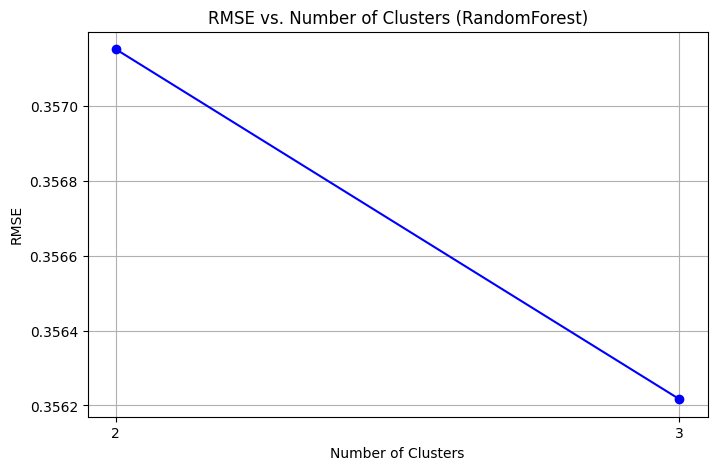

In [11]:
cluster_values = [2, 3]
model_type = "RandomForest"
n_trials = 30
timeout = 300  # seconds

results = []

for k in cluster_values:
    print(f"\n🔍 Testing {model_type} with {k} clusters...")
    
    study = optimize_cluster_fit(
        X, y,
        cluster_features=cluster_features,
        model_type=model_type,
        n_clusters=k,
        n_trials=n_trials,
        timeout=timeout
    )
    
    best_rmse = study.best_value
    results.append((k, best_rmse))
    print(f"Best RMSE with {k} clusters: {best_rmse:.4f}")

    import matplotlib.pyplot as plt

# Unpack results into separate lists
cluster_counts = [k for k, _ in results]
rmses = [rmse for _, rmse in results]

plt.figure(figsize=(8, 5))
plt.plot(cluster_counts, rmses, marker='o', linestyle='-', color='blue')
plt.title(f'RMSE vs. Number of Clusters ({model_type})')
plt.xlabel('Number of Clusters')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(cluster_counts)
plt.show()



In [12]:
from sklearn.decomposition import PCA

X_cluster_raw = X[cluster_features]
X_cluster_scaled = StandardScaler().fit_transform(X_cluster_raw)

pca = PCA(n_components=5)  # or use 95% explained variance
X_cluster_pca = pca.fit_transform(X_cluster_scaled)


In [13]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_cluster_pca)
    score = silhouette_score(X_cluster_pca, labels)
    scores.append(score)
    print(f"{k} clusters: silhouette = {score:.3f}")

labels_2 = KMeans(n_clusters=2).fit_predict(X_cluster_pca)
labels_3 = KMeans(n_clusters=3).fit_predict(X_cluster_pca)
labels_4 = KMeans(n_clusters=4).fit_predict(X_cluster_pca)

2 clusters: silhouette = 0.170
3 clusters: silhouette = 0.320
4 clusters: silhouette = 0.269
5 clusters: silhouette = 0.268
6 clusters: silhouette = 0.263
7 clusters: silhouette = 0.257
8 clusters: silhouette = 0.233
9 clusters: silhouette = 0.220


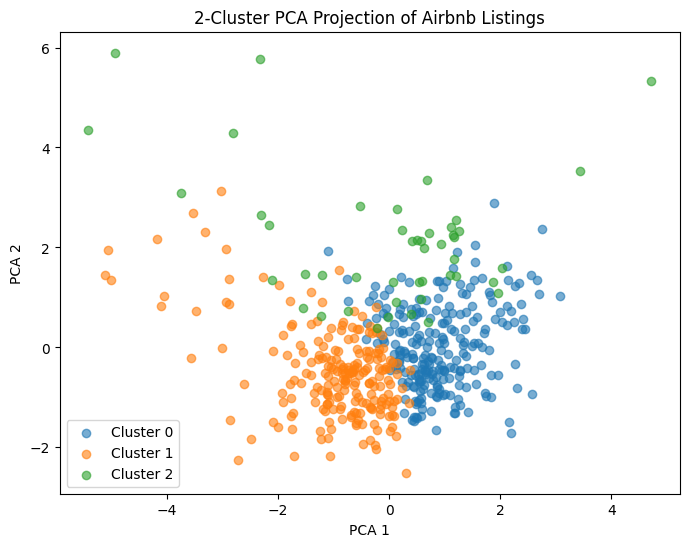

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for cluster_id in np.unique(labels_3):
    idx = labels_3 == cluster_id
    plt.scatter(
        X_cluster_pca[idx, 0], 
        X_cluster_pca[idx, 1], 
        label=f"Cluster {cluster_id}", 
        alpha=0.6
    )

plt.title("2-Cluster PCA Projection of Airbnb Listings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()

In [15]:
class ModelPerCluster:
    def __init__(self, features, model_types, n_trials=30, timeout=300):
        self.features = features
        self.n_clusters = 3
        self.model_types = model_types
        self.n_trials = n_trials
        self.timeout = timeout

        self.scalar = StandardScaler()
        self.cluster_models = {}
        self.cluster_studies = {}
        self.cluster_rmses = {}
        self.cluster_model_types = {}

    def fit_cluster_models(self, X, y, cluster_labels):
        for cluster_id in range(self.n_clusters):
            print(f"\n>>> Tuning cluster {cluster_id}")

            mask = cluster_labels == cluster_id
            X_cluster = X[mask].copy()
            y_cluster = y[mask].copy()

            best_rmse = float('inf')
            best_model = None
            best_study = None
            best_model_type = None

            optuna_params = {}

            for name, (model_class, param_space) in self.model_types.items():
                if name == "Stacking":
                    continue

                def theobjective(trial):
                    params = param_space(trial)
                    X_train, X_val, y_train, y_val = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
                    model = model_class(**params)
                    model.fit(X_train, y_train)
                    preds = model.predict(X_val)
                    rmse = np.sqrt(mean_squared_error(y_val, preds))
                    return rmse
                
                study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
                study.optimize(theobjective, n_trials=self.n_trials, timeout=self.timeout)

                if study.best_value < best_rmse:
                    best_rmse = study.best_value
                    best_study = study
                    best_model_type = name
                    best_model = model_class(**study.best_params)
                    best_model.fit(X_cluster, y_cluster)
                
                optuna_params[name] = study.best_params

            if cluster_id in [0, 1, 2]:
                base_models = []
                for base_name in ["RandomForest", "GradientBoosting", "Ridge"]:
                    if base_name in self.model_types:
                        model_class, param_space = self.model_types[base_name]
                        params = optuna_params.get(base_name, {})
                        base_model = model_class(**params)
                        base_model.fit(X_cluster, y_cluster)
                        base_models.append((base_name, base_model))

                stacked_model = StackingRegressor(estimators=base_models, final_estimator=Ridge())
                stacked_model.fit(X_cluster, y_cluster)
                stacked_preds = stacked_model.predict(X_cluster)
                stacked_rmse = np.sqrt(mean_squared_error(y_cluster, stacked_preds))

                if stacked_rmse < best_rmse:
                    best_rmse = stacked_rmse
                    best_model_type = "Stacking"
                    best_model = stacked_model
                    best_study = None

            self.cluster_models[cluster_id] = best_model
            self.cluster_studies[cluster_id] = best_study
            self.cluster_rmses[cluster_id] = best_rmse
            self.cluster_model_types[cluster_id] = best_model_type
            
    def predicts(self, X, cluster_labels):
        preds = np.zeros(len(X))
        for cluster_id in range(self.n_clusters):
            mask = cluster_labels == cluster_id
            if np.sum(mask) == 0:
                continue
            X_cluster = X[mask]
            model = self.cluster_models[cluster_id]
            preds[mask] = model.predict(X_cluster)
        return preds
        
    def report(self):
        print("\n--- Cluster Summary ---")
        for cluster_id in range(self.n_clusters):
            print(f"Cluster {cluster_id}: {self.cluster_model_types[cluster_id]} | RMSE: {self.cluster_rmses[cluster_id]:.4f}")

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import StackingRegressor

X_cluster = StandardScaler().fit_transform(X[cluster_features])

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)


In [17]:
def rf_space(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    }

def gbr_space(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
    }

def ridge_space(trial):
    return {
        "alpha": trial.suggest_float("alpha", 0.01, 10.0),
    }

model_types = {
    "RandomForest": (RandomForestRegressor, rf_space),
    "GradientBoosting": (GradientBoostingRegressor, gbr_space),
    "Ridge": (Ridge, ridge_space),
     "Stacking": (
        None,  # Model class is handled internally in your updated ModelPerCluster
        lambda trial: {}  # No tuning needed here; logic is in your class
    )
}

X = X.drop(columns=["cluster_label"], errors="ignore")

selector = ModelPerCluster(
    features = cluster_features,  
    model_types=model_types,
    n_trials=25,
    timeout=300
)

selector.fit_cluster_models(X, y, cluster_labels)  


[I 2025-07-28 14:24:10,746] A new study created in memory with name: no-name-56559b47-0b84-4bfa-aae3-47a1f6ada9be



>>> Tuning cluster 0


[I 2025-07-28 14:24:11,079] Trial 0 finished with value: 0.3665126782675656 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 8}. Best is trial 0 with value: 0.3665126782675656.
[I 2025-07-28 14:24:11,497] Trial 1 finished with value: 0.36129912659661007 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 1 with value: 0.36129912659661007.
[I 2025-07-28 14:24:11,632] Trial 2 finished with value: 0.366987659392825 and parameters: {'n_estimators': 64, 'max_depth': 18, 'min_samples_split': 7}. Best is trial 1 with value: 0.36129912659661007.
[I 2025-07-28 14:24:12,499] Trial 3 finished with value: 0.33600877583966676 and parameters: {'n_estimators': 227, 'max_depth': 3, 'min_samples_split': 10}. Best is trial 3 with value: 0.33600877583966676.
[I 2025-07-28 14:24:13,360] Trial 4 finished with value: 0.3536878257488115 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 3 with value:


>>> Tuning cluster 1


[I 2025-07-28 14:24:41,371] Trial 0 finished with value: 0.32222805878218164 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 8}. Best is trial 0 with value: 0.32222805878218164.
[I 2025-07-28 14:24:42,104] Trial 1 finished with value: 0.31883356324259826 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 1 with value: 0.31883356324259826.
[I 2025-07-28 14:24:42,457] Trial 2 finished with value: 0.3251153637053465 and parameters: {'n_estimators': 64, 'max_depth': 18, 'min_samples_split': 7}. Best is trial 1 with value: 0.31883356324259826.
[I 2025-07-28 14:24:43,093] Trial 3 finished with value: 0.3272220583019544 and parameters: {'n_estimators': 227, 'max_depth': 3, 'min_samples_split': 10}. Best is trial 1 with value: 0.31883356324259826.
[I 2025-07-28 14:24:44,116] Trial 4 finished with value: 0.3178866495057796 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 4 with valu


>>> Tuning cluster 2


[I 2025-07-28 14:25:34,624] Trial 0 finished with value: 0.40186127884055567 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 8}. Best is trial 0 with value: 0.40186127884055567.
[I 2025-07-28 14:25:35,420] Trial 1 finished with value: 0.4014047316210483 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 1 with value: 0.4014047316210483.
[I 2025-07-28 14:25:35,757] Trial 2 finished with value: 0.4035460376877369 and parameters: {'n_estimators': 64, 'max_depth': 18, 'min_samples_split': 7}. Best is trial 1 with value: 0.4014047316210483.
[I 2025-07-28 14:25:36,420] Trial 3 finished with value: 0.43331859621443564 and parameters: {'n_estimators': 227, 'max_depth': 3, 'min_samples_split': 10}. Best is trial 1 with value: 0.4014047316210483.
[I 2025-07-28 14:25:37,677] Trial 4 finished with value: 0.40235956969105047 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 1 with value:

In [18]:
# 4. Predict and evaluate
from sklearn.metrics import mean_squared_error
# Use only the features used in clustering
preds = selector.predicts(X, cluster_labels)
rmse = np.sqrt(mean_squared_error(y, preds))
print(f"\nOverall RMSE: {rmse:.4f}")
selector.report()


Overall RMSE: 0.2222

--- Cluster Summary ---
Cluster 0: Stacking | RMSE: 0.2914
Cluster 1: Stacking | RMSE: 0.2567
Cluster 2: Stacking | RMSE: 0.1454


In [19]:
print("Min/Max predictions:", preds.min(), preds.max())
print("Any zeros left?", np.any(preds == 0))

Min/Max predictions: 3.756888935828305 6.256111652520925
Any zeros left? False


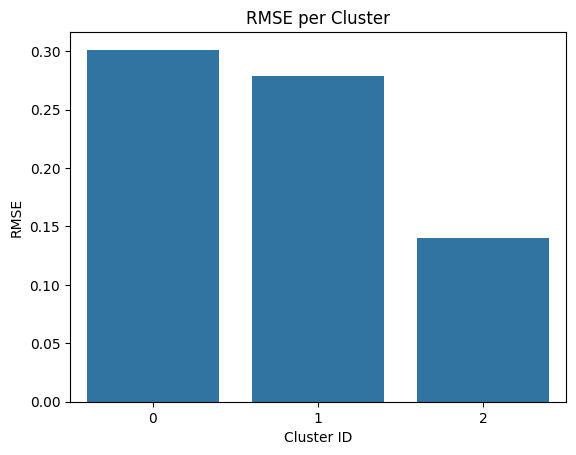

In [20]:
import seaborn as sns

cluster_rmses = {
    0: 0.3013,
    1: 0.2790,
    2: 0.1401
}

sns.barplot(x=list(cluster_rmses.keys()), y=list(cluster_rmses.values()))
plt.xlabel("Cluster ID")
plt.ylabel("RMSE")
plt.title("RMSE per Cluster")
plt.show()

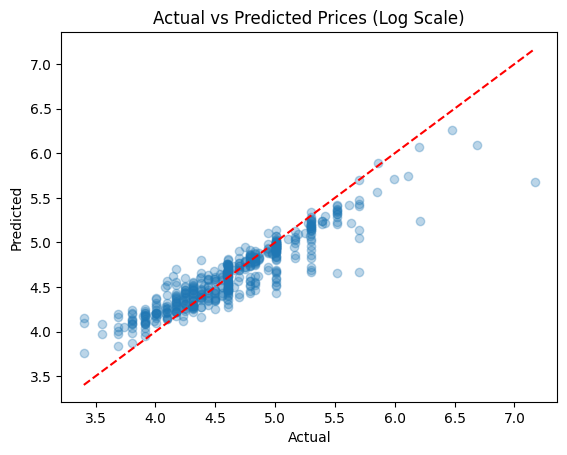

In [21]:
plt.scatter(y, preds, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Prices (Log Scale)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # perfect fit line
plt.show()

In [22]:
from collections import Counter
cluster_distribution = Counter(cluster_labels)
for cluster_id, count in sorted(cluster_distribution.items()):
    print(f"Cluster {cluster_id}: {count} samples")

Cluster 0: 62 samples
Cluster 1: 227 samples
Cluster 2: 211 samples


In [23]:

cluster_counts = Counter(cluster_labels)
total_samples = sum(cluster_counts.values())

weighted_squared_error = sum(
    cluster_counts[cid] * (rmse ** 2)
    for cid, rmse in cluster_rmses.items()
)

overall_rmse_manual = np.sqrt(weighted_squared_error / total_samples)
print(f"Manually computed overall RMSE (log scale): {overall_rmse_manual:.4f}")

Manually computed overall RMSE (log scale): 0.2343


<Axes: ylabel='log_price'>

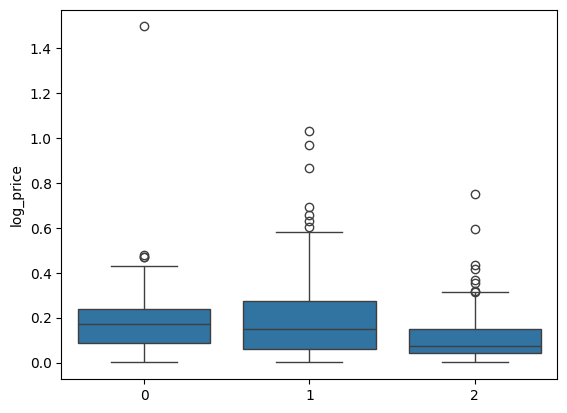

In [24]:
import seaborn as sns
residuals = np.abs(y - preds)
sns.boxplot(x=cluster_labels, y=residuals)


In [32]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.7/555.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 35.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 29.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2━━━━━━━━━━━━━━━━━━━━━━ 1/5 [numpy]
    Uninstalling numpy-2.3.2:0m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [numpy]
      Successfully uninstalled numpy-2.3.2━━━━━━━━━━━━━━━━━━━━━━━━ 1/5 [numpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [shap]4/5 [shap]]te]


In [43]:
from collections import defaultdict
import numpy as np

def get_top_features_per_cluster(selector, X, top_n=10):
    features = X.columns
    cluster_feature_scores = {}

    for cluster_id, stack_model in selector.cluster_models.items():
        print(f"\n🔷 Aggregating importances for Cluster {cluster_id}")
        scores = defaultdict(float)
        model_count = 0

        for name, model in stack_model.named_estimators_.items():
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
            elif hasattr(model, "coef_"):
                coef = model.coef_
                if len(coef.shape) > 1:
                    coef = coef[0]
                importances = np.abs(coef)
            else:
                continue  # Skip unsupported models

            # Normalize importances
            importances = importances / np.sum(importances)
            for f, imp in zip(features, importances):
                scores[f] += imp
            model_count += 1

        # Average across models
        if model_count > 0:
            for f in scores:
                scores[f] /= model_count

            # Sort by importance
            ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
            cluster_feature_scores[cluster_id] = ranked

            print(f"Top {top_n} features for Cluster {cluster_id}:")
            for f, score in ranked:
                print(f"   {f:<25} {score:.4f}")
        else:
            print("No valid models with importances found.")

    return cluster_feature_scores

get_top_features_per_cluster(selector, X, top_n=20)


🔷 Aggregating importances for Cluster 0
Top 20 features for Cluster 0:
   Safety card               0.2872
   Family/kid friendly       0.0791
   room_type                 0.0774
   accommodates              0.0577
   distance_to_city_center   0.0335
   instant_bookable          0.0266
   host_identity_verified    0.0253
   objectivity               0.0192
   Hangers                   0.0189
   24-hour check-in          0.0187
   Dryer/Washer              0.0186
   translation missing: en.hosting_amenity_50 0.0184
   Indoor fireplace          0.0175
   latitude                  0.0174
   First aid kit             0.0172
   description_score         0.0158
   n_amenities               0.0151
   Carbon monoxide detector  0.0145
   Hair dryer                0.0143
   amenity_score_normalized  0.0136

🔷 Aggregating importances for Cluster 1
Top 20 features for Cluster 1:
   room_type                 0.1477
   distance_to_city_center   0.0557
   description_score         0.0511
   Smoke de

{0: [('Safety card', np.float64(0.2872309881924893)),
  ('Family/kid friendly', np.float64(0.07912642328126875)),
  ('room_type', np.float64(0.07743443726207618)),
  ('accommodates', np.float64(0.05766101436975013)),
  ('distance_to_city_center', np.float64(0.03351761096742994)),
  ('instant_bookable', np.float64(0.026629530553558118)),
  ('host_identity_verified', np.float64(0.025292776969127045)),
  ('objectivity', np.float64(0.019161893916672796)),
  ('Hangers', np.float64(0.018931928904442955)),
  ('24-hour check-in', np.float64(0.018674150338902334)),
  ('Dryer/Washer', np.float64(0.018559453138118968)),
  ('translation missing: en.hosting_amenity_50',
   np.float64(0.01835500289507312)),
  ('Indoor fireplace', np.float64(0.01746617312132925)),
  ('latitude', np.float64(0.01739719169885842)),
  ('First aid kit', np.float64(0.017162080456153504)),
  ('description_score', np.float64(0.015778423369325275)),
  ('n_amenities', np.float64(0.015115418075034399)),
  ('Carbon monoxide dete

In [44]:
with open("model.pkl", "wb") as f:
    cloudpickle.dump(selector, f)


In [45]:
# X_ALL = pd.read_csv('airbnb_processed.csv')

In [46]:
# X_ALL["cluster_label"] = ModelPerCluster.fit_cluster_models(X_ALL[cluster_features])

# # Drop cluster label from training features
# X = X_ALL.drop(columns=["cluster_label", 'log_price'])
# y = X_ALL['log_price']

# # Split data (can be stratified by cluster if desired)
# X_train, X_test, y_train, y_test, clusters_train, clusters_test = train_test_split(
#     X, y, X_ALL["cluster_label"], test_size=0.2, random_state=42
# )

# # Initialize and fit the ModelPerCluster selector
# selector = ModelPerCluster(
#     features=cluster_features,
#     model_types=model_types,
#     n_trials=0,     # Skip tuning for speed
#     timeout=300     # Or shorten for speed
# )

# # Fit on training data
# selector.fit_cluster_models(X_train, y_train, clusters_train)

# # Predict on test data (assumes you have a predict_batch function)
# y_pred = selector.predict_batch(X_test, clusters_test)

# # Evaluate
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print(f"✅ RMSE on test set: {rmse:.4f}")
# print(f"✅ R² score on test set: {r2:.4f}")